# Seagrass Area Analysis - Plots

Visualize ground truth vs predicted seagrass area from `outputs/eval-area/`.
Run `eval-area-calc.ipynb` first to generate the CSV files.

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Directories
INPUT_DIR = Path("../outputs/eval-area")
OUTPUT_DIR = Path("../outputs/eval-plots")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Style
plt.style.use("ggplot")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 9,
    "axes.labelsize": 10,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "axes.facecolor": "white",
    "axes.edgecolor": "#cccccc",
    "axes.grid": True,
    "grid.color": "#e0e0e0",
    "grid.linewidth": 0.8,
    "axes.axisbelow": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "figure.facecolor": "white",
    "figure.dpi": 150,
    "legend.frameon": False,
})

# Color palette
COLORS = {
    "black": "#000000",
    "blue": "#3063A3",
    "red": "#E8613C",
    "yellow": "#F7B500",
    "purple": "#821C65",
    "green": "#63BB42",
}

REGION_COLORS = {
    "North": COLORS["black"],
    "Central": COLORS["blue"],
    "South": COLORS["red"],
}

# Load data
ortho_df = pd.read_csv(INPUT_DIR / "ortho_areas.csv")
print(f"Loaded {len(ortho_df)} orthos")
ortho_df.head()

Loaded 12 orthos


,ortho,region,gt_pixels,pred_pixels,resolution_cm,gt_area_m2,pred_area_m2,area_error_m2,abs_error_m2
0,bag_harbour_u0490,North,70556265,72930288,2.7,51435.517185,53166.179952,1730.662767,1730.662767
1,beck_u0409,South,16048845,12696795,5.0,40122.112500,31741.987500,-8380.125000,8380.125000
2,mcmullin_north_u0900,Central,25361335,27486982,2.3,13416.146215,14540.613478,1124.467263,1124.467263
3,mcmullin_north_u1270,Central,22557954,19776298,2.5,14098.721250,12360.186250,-1738.535000,1738.535000
4,section_cove_u0249,North,5697545,5098348,4.4,11030.447120,9870.401728,-1160.045392,1160.045392


In [3]:
# Calculate MAE metrics
overall_mae = ortho_df["abs_error_m2"].mean()
mae_by_region = ortho_df.groupby("region")["abs_error_m2"].mean()

# Additional metrics
overall_rmse = np.sqrt((ortho_df["area_error_m2"] ** 2).mean())
overall_bias = ortho_df["area_error_m2"].mean()

# Percentage error (relative to GT)
ortho_df["pct_error"] = (ortho_df["area_error_m2"] / ortho_df["gt_area_m2"].replace(0, np.nan)) * 100
mean_pct_error = ortho_df["pct_error"].mean()

print("=" * 50)
print("AREA ESTIMATION METRICS")
print("=" * 50)
print(f"\nOverall Metrics:")
print(f"  MAE:  {overall_mae:,.1f} m²")
print(f"  RMSE: {overall_rmse:,.1f} m²")
print(f"  Bias: {overall_bias:+,.1f} m²")
print(f"  Mean % Error: {mean_pct_error:+.1f}%")
print(f"\nMAE by Region:")
for region, mae in mae_by_region.items():
    print(f"  {region}: {mae:,.1f} m²")

AREA ESTIMATION METRICS

Overall Metrics:
  MAE:  2,875.5 m²
  RMSE: 3,557.7 m²
  Bias: -2,399.6 m²
  Mean % Error: -13.7%

MAE by Region:
  Central: 2,675.2 m²
  North: 2,124.9 m²
  South: 8,380.1 m²


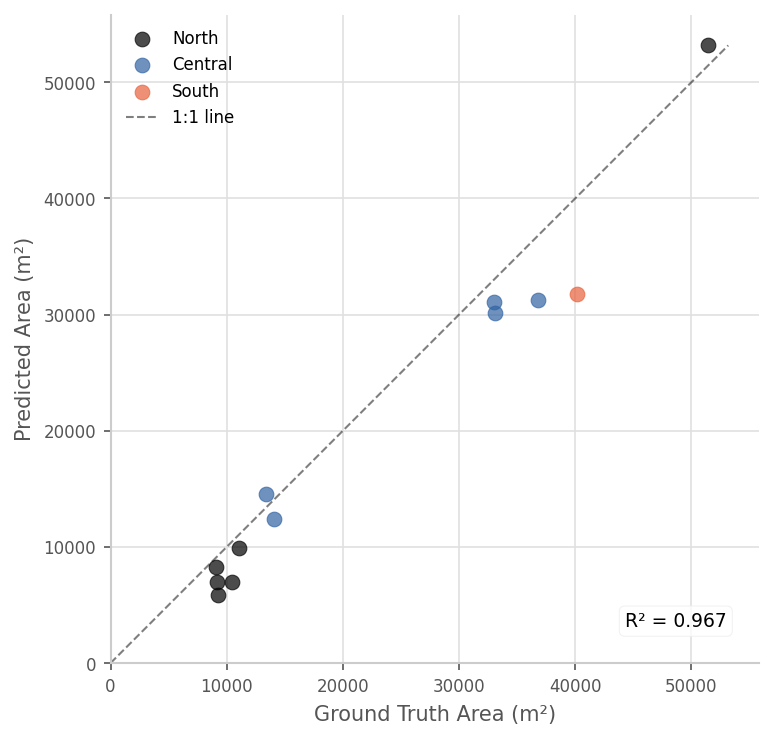

In [4]:
# Scatter Plot - GT vs Predicted Area
fig, ax = plt.subplots(figsize=(5.5, 5))

# Plot by region
for region in ["North", "Central", "South"]:
    mask = ortho_df["region"] == region
    if mask.sum() > 0:
        ax.scatter(
            ortho_df.loc[mask, "gt_area_m2"],
            ortho_df.loc[mask, "pred_area_m2"],
            c=REGION_COLORS[region],
            label=region,
            alpha=0.7,
            s=50,
        )

# 1:1 reference line
max_val = max(ortho_df["gt_area_m2"].max(), ortho_df["pred_area_m2"].max())
ax.plot([0, max_val], [0, max_val], "k--", linewidth=1, alpha=0.5, label="1:1 line")

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    ortho_df["gt_area_m2"], ortho_df["pred_area_m2"]
)
r_squared = r_value ** 2

ax.set_xlabel("Ground Truth Area (m²)")
ax.set_ylabel("Predicted Area (m²)")
ax.set_xlim(0, max_val * 1.05)
ax.set_ylim(0, max_val * 1.05)
ax.legend(loc="upper left", fontsize=8)
ax.set_aspect("equal")

# Add R² annotation
ax.text(
    0.95, 0.05, f"R² = {r_squared:.3f}",
    transform=ax.transAxes, ha="right", va="bottom", fontsize=9,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "area_scatter.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / "area_scatter.pdf", bbox_inches="tight")
plt.show()

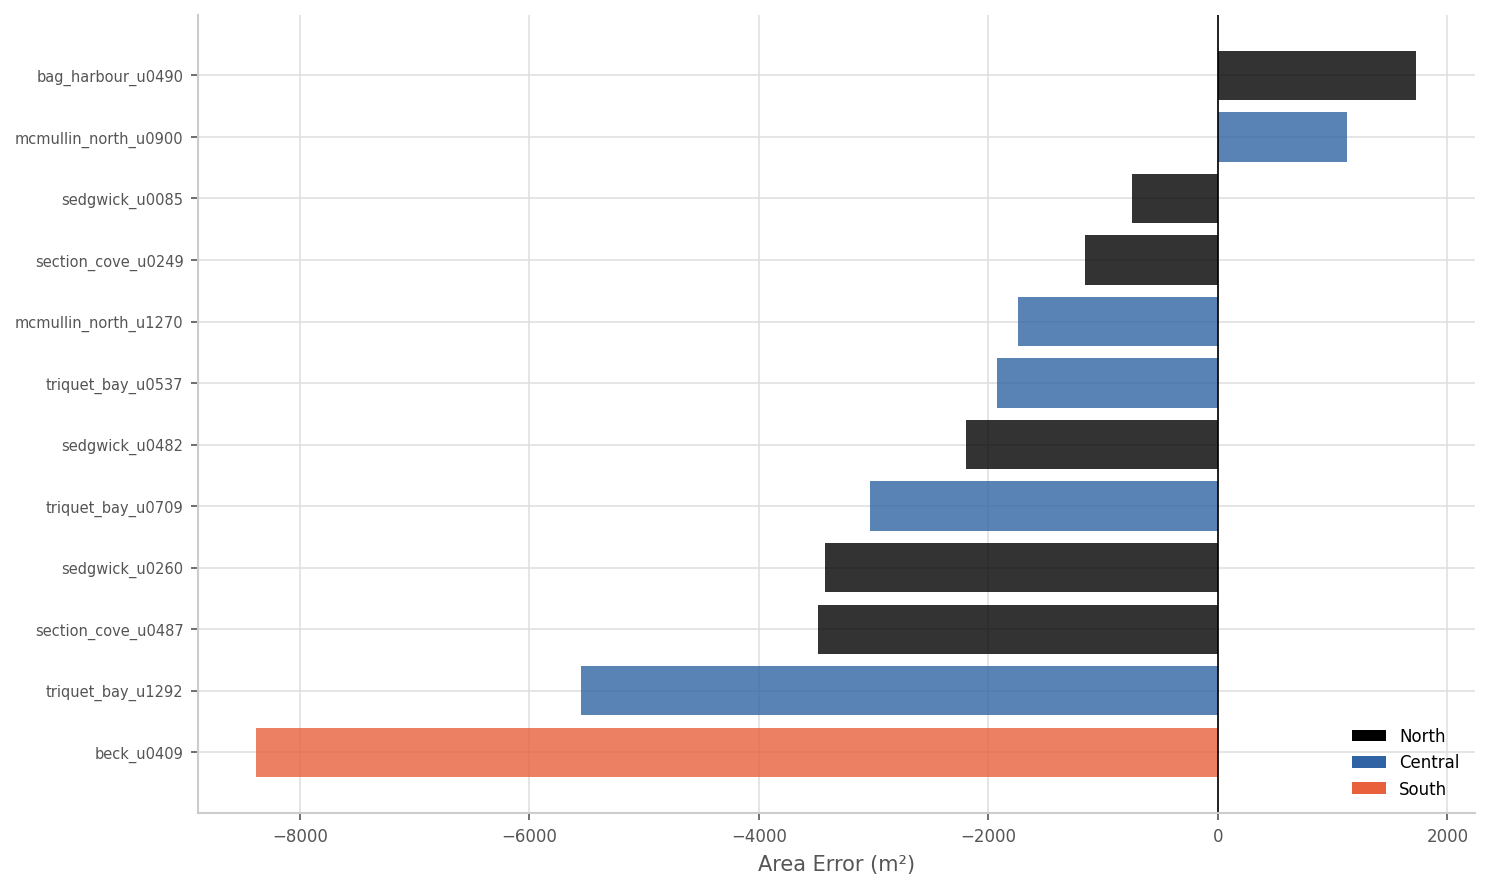

In [5]:
# Bar Chart - Error by Ortho (sorted by error)
sorted_df = ortho_df.sort_values("area_error_m2")

fig, ax = plt.subplots(figsize=(10, 6))

colors = [REGION_COLORS.get(r, COLORS["black"]) for r in sorted_df["region"]]
bars = ax.barh(range(len(sorted_df)), sorted_df["area_error_m2"], color=colors, alpha=0.8)

ax.set_yticks(range(len(sorted_df)))
ax.set_yticklabels(sorted_df["ortho"], fontsize=7)
ax.set_xlabel("Area Error (m²)")
ax.axvline(0, color="black", linewidth=0.8)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=r) for r, c in REGION_COLORS.items()]
ax.legend(handles=legend_elements, loc="lower right", fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "area_error_by_ortho.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / "area_error_by_ortho.pdf", bbox_inches="tight")
plt.show()

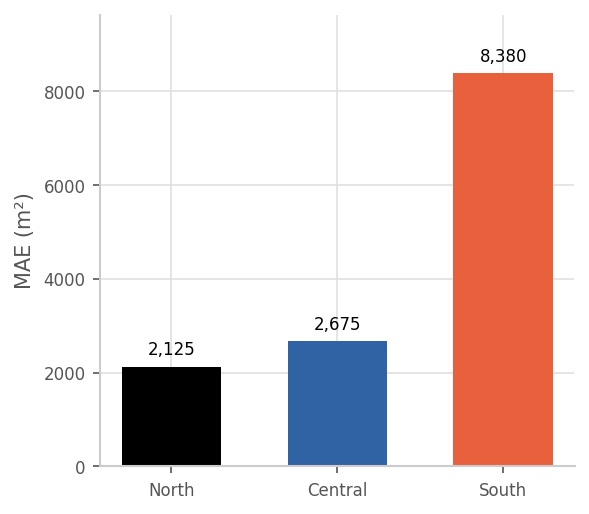

In [6]:
# MAE by Region - Bar Chart
fig, ax = plt.subplots(figsize=(4, 3.5))

regions = ["North", "Central", "South"]
mae_values = [mae_by_region.get(r, 0) for r in regions]
colors = [REGION_COLORS[r] for r in regions]

bars = ax.bar(regions, mae_values, color=colors, width=0.6)

# Value labels
for bar, val in zip(bars, mae_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(mae_values) * 0.02,
        f"{val:,.0f}",
        ha="center", va="bottom", fontsize=8
    )

ax.set_ylabel("MAE (m²)")
ax.set_ylim(0, max(mae_values) * 1.15)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "mae_by_region.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / "mae_by_region.pdf", bbox_inches="tight")
plt.show()

In [7]:
# Summary table
summary_data = {
    "Metric": ["MAE (m²)", "RMSE (m²)", "Bias (m²)", "Mean % Error", "R²"],
    "Value": [
        f"{overall_mae:,.1f}",
        f"{overall_rmse:,.1f}",
        f"{overall_bias:+,.1f}",
        f"{mean_pct_error:+.1f}%",
        f"{r_squared:.3f}",
    ]
}
summary_df = pd.DataFrame(summary_data)

print("\nSummary Table:")
display(summary_df)

print("\nMAE by Region:")
display(mae_by_region.to_frame("MAE (m²)").round(1))


Summary Table:


,Metric,Value
0,MAE (m²),"2,875.5"
1,RMSE (m²),"3,557.7"
2,Bias (m²),"-2,399.6"
3,Mean % Error,-13.7%
4,R²,0.967



MAE by Region:


,MAE (m²)
region,
Central,2675.2
North,2124.9
South,8380.1


In [ ]:
# Time Series Bar Chart - Triquet Bay
# Shows predicted vs ground truth area over time to observe trends

# Extract location and time identifier
ortho_df["location"] = ortho_df["ortho"].str.rsplit("_", n=1).str[0]
ortho_df["time_id"] = ortho_df["ortho"].str.rsplit("_", n=1).str[1]

# Filter for triquet_bay only
triquet_df = ortho_df[ortho_df["location"] == "triquet_bay"].copy()

# Map flight IDs to years
year_map = {"u0537": "2018", "u0709": "2019", "u1292": "2024"}
triquet_df["year"] = triquet_df["time_id"].map(year_map)
triquet_df = triquet_df.sort_values("year")

fig, ax = plt.subplots(figsize=(5, 4))

bar_width = 0.35
x = np.arange(len(triquet_df))

# Ground truth bars
bars_gt = ax.bar(
    x - bar_width/2,
    triquet_df["gt_area_m2"],
    bar_width,
    label="Ground Truth",
    color=COLORS["blue"],
    alpha=0.8,
)

# Predicted bars
bars_pred = ax.bar(
    x + bar_width/2,
    triquet_df["pred_area_m2"],
    bar_width,
    label="Predicted",
    color=COLORS["red"],
    alpha=0.8,
)

ax.set_xlabel("Year")
ax.set_ylabel("Area (m²)")
ax.set_title("Triquet Bay")
ax.set_xticks(x)
ax.set_xticklabels(triquet_df["year"], fontsize=9)
ax.legend(loc="upper left", fontsize=8)

# Add value labels on bars
for bar in bars_gt:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height/1000:.1f}k",
        ha="center", va="bottom", fontsize=7,
    )
for bar in bars_pred:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height/1000:.1f}k",
        ha="center", va="bottom", fontsize=7,
    )

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "triquet_bay_time_series.png", dpi=300, bbox_inches="tight")
plt.savefig(OUTPUT_DIR / "triquet_bay_time_series.pdf", bbox_inches="tight")
plt.show()

# Print summary
print("\nTriquet Bay Time Series Summary:")
for _, row in triquet_df.iterrows():
    pct_err = (row["area_error_m2"] / row["gt_area_m2"]) * 100
    print(f"  {row['year']}: GT={row['gt_area_m2']/1000:.1f}k m², Pred={row['pred_area_m2']/1000:.1f}k m², Error={pct_err:+.1f}%")